In [186]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, DatetimeTickFormatter, Band
from bokeh.layouts import gridplot
import pandas as pd
from datetime import datetime, timedelta
from bokeh.models import HoverTool, DatetimeTickFormatter, Band, ColumnDataSource

In [31]:
# Настройки подключения к БД
# Создаем подключение
connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database_name}'
engine = create_engine(connection_string)

# Выполнение SQL-запроса и сохранение результатов в датафрейме
sql_query = """
SELECT *
FROM market_data
"""
df = pd.read_sql(sql_query, engine)

In [15]:
def simple_moving_average(prices, window_size):
    k = 0
    p = 0
    sma = []
    for i in prices:
        if k <= (len(prices)- window_size):
            sma.append((prices[k:k+window_size].sum())/window_size)
        else:
            p+=1
            sma.append((prices[k:k+window_size].sum())/(window_size-p))
        k+=1
    return sma

Индикатор RSI показывает силу тренда и вероятность его смены (https://ru.tradingview.com/chart/BTCUSD/Eq8tysZA-indikator-rsi-sekrety-torgovli-pravila-primeneniya-polnyj-razbor/)
 
🔹если значение индикатора поднимается к 70 и выше - актив перекуплен и входить в покупки сейчас неблагоразумно, а еще лучше - нужно выходить из актива;   

🔹если значение индикатора опускается ниже 30 - актив перепродан и вы рискуете продать его на самом дне. Это хорошая возможность, чтобы рассматривать покупки. 

Еще один дополнительный сигнал от индикатора RSI - определение направления текущей тенденции.   
Принято считать, что если значение индикатора пересекает отметку в 50 - то тренд меняется. Довольно часто можно заметить, как при сильных трендах цена находит поддержку/сопротивление на этом уровне.

📊НАХОЖДЕНИЕ ДИВЕРГЕНЦИИ  

Один из самых надежных методов торговли, используя индикатор RSI. Дивергенция - это момент расхождения значений индикатора и цены, которая намекает на скорую смену тенденции в сторону направления значения индикатора.   

К примеру, «медвежья дивергенция» - момент, когда максимумы цены повышаются, но, при этом максимумы значений индикатора RSI понижаются. Это говорит о возможном скором развороте движения(цена пойдет в сторону направления значений индикатора) 

«Бычья дивергенция» - когда минимумы цены понижаются, но, в это же время, минимумы значений индикатора RSI повышаются. Это свидетельствует о том, что в ближайшее время ожидается смена тенденции/разворот

Оптимальным периодом для индикатора RSI является период 14от.   я. 

In [61]:
def RSI(prices, window_size):
    k = 0
    sma_u = []
    sma_d = []
    RSI = []
    u = 0
    for i in range(len(prices)):
        if i == 0:
            u = prices.iloc[0]
        else:
            u = prices.iloc[i] - prices.iloc[i-1]
        if u > 0:
            sma_u.append(u)
            sma_d.append(0)
        else:
            sma_d.append(abs(u))
            sma_u.append(0)
    sma_u = simple_moving_average(np.array(sma_u), window_size)
    sma_d = simple_moving_average(np.array(sma_d), window_size)
    for i in range(len(prices)):
        if sma_d[i] != 0:
            RSI.append(100 - (100/(1 + (sma_u[i]/sma_d[i]))))
        else:
            RSI.append(RSI[i-1])
    return RSI

Stochastic — это индикатор, который показывает, насколько текущая цена выбранного актива близка к своим максимумам или минимумам за установленный период. Благодаря Stochastic инвесторы могут быстро заметить смену тренда  с восходящего на нисходящий или наоборот (https://www.tbank.ru/invest/help/educate/trading/about/stochastic/)

.
Когда покупать актив: если линии индикатора Stochastic пересекают уровень 20% снизу вверх. Так индикатор показывает, что нисходящий тренд заканчивается. То есть в этот момент можно купить актив в самом начале роста.

Когда продавать актив: если линии индикатора Stochastic пересекают уровень 80% сверху вниз. Так индикатор показывает, что восходящий тренд заканчивается. То есть в этот момент можно продать актив в самом начале паден

Какая линия должна пересекать уровни: сначала уровни 20 или 80% пересекает сплошная линия — сделку можно совершать уже в этот момент. А можно дождаться подтверждения, когда уровень пересечет и вторая линия. 

Менее распространенной является стратегия, при которой инвесторы покупают и продают актив, когда пересекаются сами линии Stochastic. Так индикатор тоже показывает, что рост или падение цены заканчивается.

Когда покупать актив: если сплошная линия поднимается выше пунктирной. Это пересечение показывает, что рост цен ускоряется по сравнению с его средними значениям

Когда продавать актив: если сплошная линия опускается ниже пунктирной. Это пересечение показывает, что рост цен замедляется по сравнению с его средними значениями.и.ия.

In [66]:
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    low_min = data.loc[:,'low'].rolling(window=k_period).min()
    high_max = data.loc[:,'high'].rolling(window=k_period).max()
    data.loc[:,'%K'] = 100 * ((data.loc[:,'close'] - low_min) / (high_max - low_min))
    data.loc[:,'%D'] = data['%K'].rolling(window=d_period).mean()
    return data

MACD — это индикатор, который отсеивает незначительные краткосрочные движения цены и позволяет купить или продать актив на первых этапах нового тренда.
Торговать с помощью MACD просто:

актив нужно покупать, когда столбцы переходят из красной зоны в зеленую;
актив нужно продавать, когда столбцы переходят из зеленой зоны в красную.
Столбцы переходят из одной зоны в другую в моменты, когда происходит пересечение линии MACD и сигнальной линии. Так происходит, потому что размер столбцов равен разнице между значениями этих двух линий.



In [18]:
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # Рассчитываем короткую EMA
    ema_short = data.ewm(span=short_period, adjust=False).mean()
    
    # Рассчитываем длинную EMA
    ema_long = data.ewm(span=long_period, adjust=False).mean()
    
    # Вычисляем MACD как разницу между короткой и длинной EMA
    macd = ema_short - ema_long
    
    # Рассчитываем сигнальную линию как EMA от MACD
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    
    Bar_chart = macd - signal_line
    return macd, signal_line

In [79]:
def percentage_change(data):
    data_change = []
    for i in range(len(data)):
        if i == 0:
            data_change.append(1)
        else:
            if data.iloc[i-1] != 0:
                data_change.append((data.iloc[i] - data.iloc[i-1])*100/(data.iloc[i-1]))
            else:
                data_change.append(0)
    data = data_change
    return data_change

In [20]:
def group_by_months(dataset, name_column):
    dataset.loc[:,'month'] = pd.to_datetime(dataset.index).month
    grouped = dataset.groupby(['month'])[name_column].mean().reset_index()
    return grouped

In [21]:
def log_ago(data, period):
    log = []
    for i in range(len(data)):
        if i >= period:
            log.append(data.iloc[i-period])
        else:
            log.append(math.nan)
    return log
            

In [32]:
df.head()

,open,high,low,close,adj_close,volume,ticker,asset_name,business_date,created_datetime
0,75.690002,76.459999,74.269997,76.080002,76.080002,317628,CL=F,WTI,2022-01-03,2024-11-01 12:03:51
1,76.019997,77.639999,75.699997,76.989998,76.989998,372848,CL=F,WTI,2022-01-04,2024-11-01 12:03:51
2,77.180000,78.580002,76.510002,77.849998,77.849998,397898,CL=F,WTI,2022-01-05,2024-11-01 12:03:51
3,77.239998,80.239998,76.730003,79.459999,79.459999,476665,CL=F,WTI,2022-01-06,2024-11-01 12:03:51
4,79.620003,80.470001,78.519997,78.900002,78.900002,414434,CL=F,WTI,2022-01-07,2024-11-01 12:03:51


In [33]:
df.describe()

,open,high,low,close,adj_close,volume,created_datetime
count,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2.849000e+03,2849
mean,247.056448,249.223742,244.748427,247.063264,244.195642,3.347461e+07,2024-11-01 12:03:51.000000256
min,66.279999,67.699997,63.639999,65.750000,65.750000,0.000000e+00,2024-11-01 12:03:51
25%,82.790001,83.669998,81.709999,82.750000,82.750000,5.994500e+04,2024-11-01 12:03:51
50%,129.570007,137.000000,122.500000,127.980003,127.980003,8.722440e+05,2024-11-01 12:03:51
75%,409.660004,412.690002,407.579987,410.540009,400.665009,6.246210e+07,2024-11-01 12:03:51
max,585.909973,586.119995,582.580017,584.590027,584.590027,2.517839e+08,2024-11-01 12:03:51
std,170.673394,171.256430,169.982379,170.691634,168.104908,3.893489e+07,NaN


In [34]:
df["asset_name"].unique()

array(['WTI', 'BRENT', 'S&P 500', 'Nasdaq-100'], dtype=object)

In [35]:
df.describe(include = 'object')

,ticker,asset_name,business_date
count,2849,2849,2849
unique,4,4,713
top,BZ=F,BRENT,2022-01-03
freq,713,713,4


In [36]:
df.head()

,open,high,low,close,adj_close,volume,ticker,asset_name,business_date,created_datetime
0,75.690002,76.459999,74.269997,76.080002,76.080002,317628,CL=F,WTI,2022-01-03,2024-11-01 12:03:51
1,76.019997,77.639999,75.699997,76.989998,76.989998,372848,CL=F,WTI,2022-01-04,2024-11-01 12:03:51
2,77.180000,78.580002,76.510002,77.849998,77.849998,397898,CL=F,WTI,2022-01-05,2024-11-01 12:03:51
3,77.239998,80.239998,76.730003,79.459999,79.459999,476665,CL=F,WTI,2022-01-06,2024-11-01 12:03:51
4,79.620003,80.470001,78.519997,78.900002,78.900002,414434,CL=F,WTI,2022-01-07,2024-11-01 12:03:51


In [38]:
df = df.drop(columns=['adj_close'])

In [39]:
df = df.set_index("business_date")

OHLC = Weighted OHLC Average
Цены OHLC – это сокращённая аббревиатура, обозначающее котировки за какой-то промежуток времени. Буквы в аббревиатуре расшифровываются. O – Open – открытие свечи, бара. H – High – максимум свечи. L – Low – минимум свечи. C – Close – закрытие свечи

In [41]:
df['OHLS'] = df.apply(lambda x: (x['open'] +  x['high'] +  x['low'] +  x['close']) /4, axis = 1)

In [42]:
df.head(2)

,open,high,low,close,volume,ticker,asset_name,created_datetime,OHLS
business_date,,,,,,,,,
2022-01-03,75.690002,76.459999,74.269997,76.080002,317628,CL=F,WTI,2024-11-01 12:03:51,75.625000
2022-01-04,76.019997,77.639999,75.699997,76.989998,372848,CL=F,WTI,2024-11-01 12:03:51,76.587498


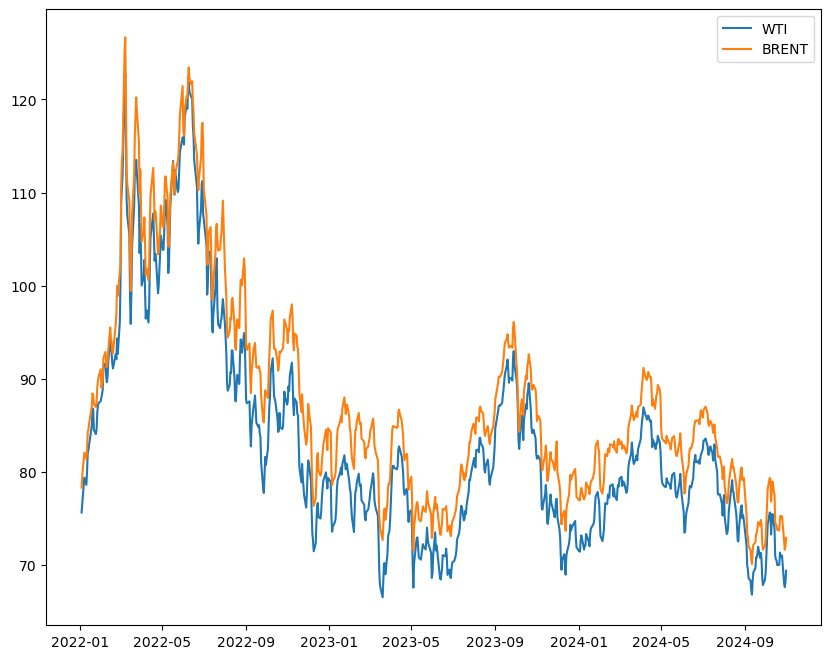

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(df[df['asset_name'] == 'WTI']["OHLS"])
plt.plot(df[df['asset_name'] == 'BRENT']["OHLS"])
plt.legend(["WTI", "BRENT"])

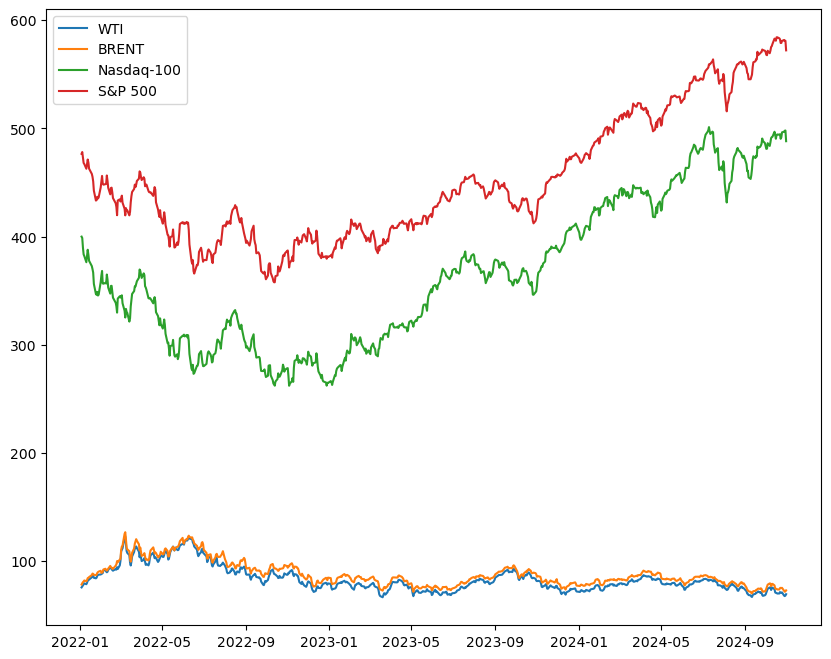

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(df[df['asset_name'] == 'WTI']["OHLS"])
plt.plot(df[df['asset_name'] == 'BRENT']["OHLS"])
plt.plot(df[df['asset_name'] == 'Nasdaq-100']["OHLS"])
plt.plot(df[df['asset_name'] == 'S&P 500']["OHLS"])
plt.legend(["WTI", "BRENT", "Nasdaq-100", 'S&P 500'])

<Axes: >

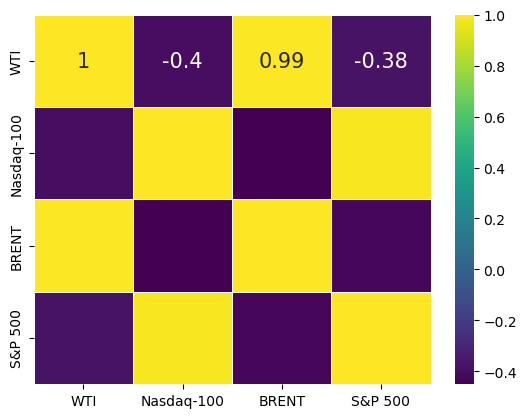

In [48]:
corr = pd.DataFrame()
corr["WTI"] = df[df['asset_name'] == 'WTI']["OHLS"]
corr["Nasdaq-100"] = df[df['asset_name'] == 'Nasdaq-100']["OHLS"]
corr["BRENT"] = df[df['asset_name'] == 'BRENT']["OHLS"]
corr["S&P 500"] = df[df['asset_name'] == 'S&P 500']["OHLS"]
sns.heatmap(corr.corr(numeric_only=True),
           linewidths=0.5,
            annot=True,
            cmap='viridis',
            annot_kws={'size': 15})

In [195]:
WTI = df[df['asset_name'] == 'WTI']
Nasdaq = df[df['asset_name'] == 'Nasdaq-100']
BRENT = df[df['asset_name'] == 'BRENT']
SP500 = df[df['asset_name'] == 'S&P 500']

In [196]:
WTI

,open,high,low,close,volume,ticker,asset_name,created_datetime,OHLS
business_date,,,,,,,,,
2022-01-03,75.690002,76.459999,74.269997,76.080002,317628,CL=F,WTI,2024-11-01 12:03:51,75.625000
2022-01-04,76.019997,77.639999,75.699997,76.989998,372848,CL=F,WTI,2024-11-01 12:03:51,76.587498
2022-01-05,77.180000,78.580002,76.510002,77.849998,397898,CL=F,WTI,2024-11-01 12:03:51,77.530001
2022-01-06,77.239998,80.239998,76.730003,79.459999,476665,CL=F,WTI,2024-11-01 12:03:51,78.417500
2022-01-07,79.620003,80.470001,78.519997,78.900002,414434,CL=F,WTI,2024-11-01 12:03:51,79.377501
...,...,...,...,...,...,...,...,...,...
2024-10-25,70.330002,71.919998,69.959999,71.779999,287189,CL=F,WTI,2024-11-01 12:03:51,70.997499
2024-10-28,68.980003,69.000000,66.919998,67.379997,419623,CL=F,WTI,2024-11-01 12:03:51,68.070000
2024-10-29,68.019997,68.519997,66.720001,67.209999,291929,CL=F,WTI,2024-11-01 12:03:51,67.617498


In [198]:
WTI.loc[:, 'sma'] = simple_moving_average(WTI.loc[:,'OHLS'], 30)

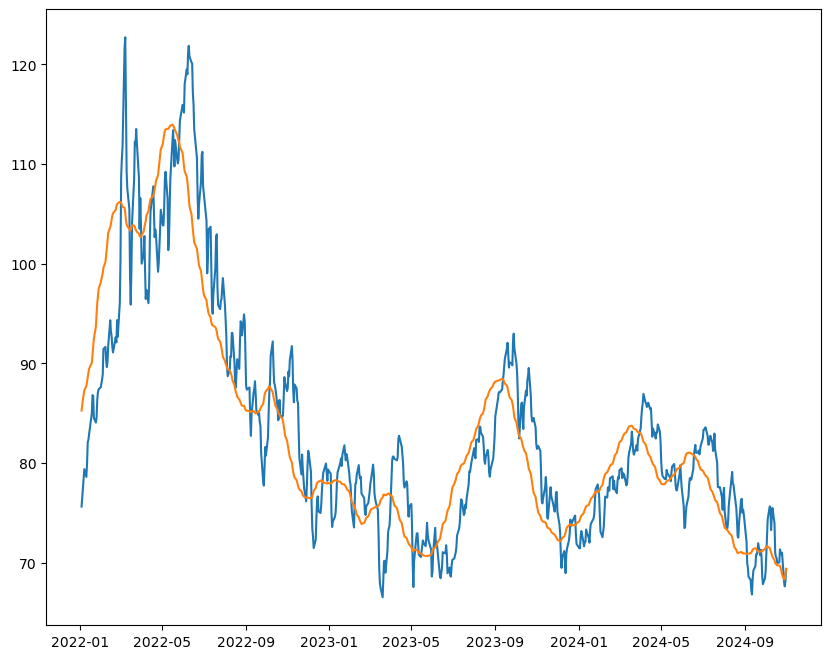

In [199]:
plt.figure(figsize=(10, 8))
plt.plot(WTI["OHLS"])
plt.plot(WTI["sma"])

In [200]:
dataset_2022_2023 = WTI[(WTI.index > pd.to_datetime('2022-01-01').date()) & (WTI.index < pd.to_datetime('2022-12-31').date())]
dataset_2023_2024 = WTI[(WTI.index > pd.to_datetime('2023-01-01').date()) & (WTI.index < pd.to_datetime('2023-12-31').date())]

In [203]:
WTI.loc[:, 'RSI'] = RSI(WTI.loc[:,'close'], 14)

In [204]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, Legend, DatetimeTickFormatter
from datetime import datetime
from datetime import timedelta
output_notebook() 

# Создаем фигуру
p = figure(width=1000, height=600,
           tools="pan,wheel_zoom,box_select,reset,hover",
           title="График RSI, OHLS и SMA",
           x_axis_type="datetime")  


rsi_line = p.line(x=WTI.index, y=WTI["RSI"], legend_label="RSI", line_color="blue")
ohls_line = p.line(x=WTI.index, y=WTI["OHLS"], legend_label="OHLS", line_color="orange")
sma_line = p.line(x=WTI.index, y=WTI["sma"], legend_label="SMA", line_color="green")

date_19350 = datetime(2022, 1, 1)
date_19750 = datetime(2025, 1, 1)


p.line([date_19350, date_19750], [70, 70], line_dash='dashed', line_color='red', legend_label="Верхняя граница")
p.line([date_19350, date_19750], [50, 50], line_dash='dashed', line_color='blue', legend_label="Середина")
p.line([date_19350, date_19750], [30, 30], line_dash='dashed', line_color='green', legend_label="Нижняя граница")


legend = Legend(items=[
    ("RSI", [rsi_line]),
    ("OHLS", [ohls_line]),
    ("SMA", [sma_line]),
    ("Верхняя граница", []),
    ("Нижняя граница", [])
])
p.add_layout(legend, 'right')

# Настраиваем инструмент hover
hover = p.select_one(HoverTool)
hover.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X
p.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Показываем график
show(p)

Loading BokehJS ...

🔹если значение индикатора поднимается к 70 и выше - актив перекуплен и входить в покупки сейчас неблагоразумно, а еще лучше - нужно выходить из актива;   

🔹если значение индикатора опускается ниже 30 - актив перепродан и вы рискуете продать его на самом дне. Это хорошая возможность, чтобы рассматривать покупки.  

Еще один дополнительный сигнал от индикатора RSI - определение направления текущей тенденции.   

Принято считать, что если значение индикатора пересекает отметку в 50 - то тренд меняется. Довольно часто можно заметить, как при сильных трендах цена находит поддержку/сопротивление на этом уровне.

In [207]:
WTI = calculate_stochastic_oscillator(WTI)

In [208]:
macd, signal = calculate_macd(WTI['close'])

In [210]:
WTI.loc[:,'macd'] = macd
WTI.loc[:,'signal'] = signal

In [169]:
p1 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="График OHLS",
    x_axis_type="datetime"
)

ohls_line = p1.line(x=WTI.index, y=WTI["OHLS"], legend_label="OHLS", line_color="orange")

# Настраиваем инструмент hover для первого графика
hover1 = p1.select_one(HoverTool)
hover1.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover1.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X для первого графика
p1.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Создаем второй график для MACD и Signal
p2 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="Графики MACD и Signal",
    x_range=p1.x_range,  # синхронизация осей X между двумя графиками
    x_axis_type="datetime"
)

macd_line = p2.line(x=WTI.index, y=WTI["macd"], legend_label="MACD", line_color="blue")
signal_line = p2.line(x=WTI.index, y=WTI["signal"], legend_label="Signal", line_color="green")

# Настраиваем инструмент hover для второго графика
hover2 = p2.select_one(HoverTool)
hover2.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover2.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X для второго графика
p2.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Создаем третий график для гистограммы разницы между MACD и Signal
p3 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="Гистограмма разницы между MACD и Signal",
    x_range=p1.x_range,  # синхронизация осей X между всеми тремя графиками
    x_axis_type="datetime"
)

difference = WTI['macd'] - WTI['signal']
positive_differences = difference[difference >= 0]
negative_differences = difference[difference < 0]

# Гистограмма для положительных значений
p3.quad(top=positive_differences, bottom=0, left=positive_differences.index - timedelta(days=0.5), right=positive_differences.index + timedelta(days=0.5), fill_color='green', line_color='green')

# Гистограмма для отрицательных значений
p3.quad(top=negative_differences, bottom=0, left=negative_differences.index - timedelta(days=0.5), right=negative_differences.index + timedelta(days=0.5), fill_color='red', line_color='red')

# Настраиваем инструмент hover для третьего графика
hover3 = p3.select_one(HoverTool)
hover3.tooltips = [
    ('Дата', '@x{%F}'),
    ('Разница', '@top')
]
hover3.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X для третьего графика
p3.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Размещаем графики друг под другом
grid = gridplot([[p1], [p2], [p3]])

# Показываем все три графика вместе
show(grid)

актив нужно покупать, когда столбцы переходят из красной зоны в зеленую; актив нужно продавать, когда столбцы переходят из зеленой зоны в красную. Столбцы переходят из одной зоны в другую в моменты, когда происходит пересечение линии MACD и сигнальной линии. Так происходит, потому что размер столбцов равен разнице между значениями этих двух линий.

In [170]:
WTI

,open,high,low,close,volume,ticker,asset_name,created_datetime,OHLS,sma,RSI,%K,%D,macd,signal,volume_change,OHLS_change,OHLS_3_ago
business_date,,,,,,,,,,,,,,,,,,
2022-01-03,75.690002,76.459999,74.269997,76.080002,317628,CL=F,WTI,2024-11-01 12:03:51,75.625000,85.263667,96.131347,NaN,NaN,0.000000,0.000000,1.000000,1.000000,NaN
2022-01-04,76.019997,77.639999,75.699997,76.989998,372848,CL=F,WTI,2024-11-01 12:03:51,76.587498,85.848917,70.049923,NaN,NaN,0.072592,0.014518,17.385117,1.272724,NaN
2022-01-05,77.180000,78.580002,76.510002,77.849998,397898,CL=F,WTI,2024-11-01 12:03:51,77.530001,86.386667,72.179304,NaN,NaN,0.197243,0.051063,6.718556,1.230622,NaN
2022-01-06,77.239998,80.239998,76.730003,79.459999,476665,CL=F,WTI,2024-11-01 12:03:51,78.417500,86.857667,73.399029,NaN,NaN,0.421090,0.125069,19.795777,1.144717,75.625000
2022-01-07,79.620003,80.470001,78.519997,78.900002,414434,CL=F,WTI,2024-11-01 12:03:51,79.377501,87.280333,68.399400,NaN,NaN,0.546997,0.209454,-13.055500,1.224218,76.587498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,70.330002,71.919998,69.959999,71.779999,287189,CL=F,WTI,2024-11-01 12:03:51,70.997499,68.837000,44.336173,31.627404,22.756714,-0.254865,-0.106765,0.215653,0.236484,71.322500
2024-10-28,68.980003,69.000000,66.919998,67.379997,419623,CL=F,WTI,2024-11-01 12:03:51,68.070000,68.296875,30.966801,4.935613,17.305381,-0.556512,-0.196714,46.113883,-4.123384,70.992498
2024-10-29,68.019997,68.519997,66.720001,67.209999,291929,CL=F,WTI,2024-11-01 12:03:51,67.617498,68.372499,92.342429,5.147038,13.903352,-0.800064,-0.317384,-30.430648,-0.664759,70.829998


In [211]:
p1 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="График OHLS",
    x_axis_type="datetime"
)

ohls_line = p1.line(x=WTI.index, y=WTI["OHLS"], legend_label="OHLS", line_color="orange")

# Настраиваем инструмент hover для первого графика
hover1 = p1.select_one(HoverTool)
hover1.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover1.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X для первого графика
p1.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Создаем второй график для MACD и Signal
p2 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="Stochastic",
    x_range=p1.x_range,  # синхронизация осей X между двумя графиками
    x_axis_type="datetime"
)

macd_line = p2.line(x=WTI.index, y=WTI["%K"], legend_label="%K", line_color="blue")
signal_line = p2.line(x=WTI.index, y=WTI["%D"], legend_label="%D", line_color="green")
date_19350 = datetime(2022, 1, 1)
date_19750 = datetime(2025, 1, 1)


p.line([date_19350, date_19750], [80, 80], line_dash='dashed', line_color='green')
p.line([date_19350, date_19750], [20, 20], line_dash='dashed', line_color='green')

# Настраиваем инструмент hover для второго графика
hover2 = p2.select_one(HoverTool)
hover2.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover2.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X для второго графика
p2.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Размещаем графики друг под другом
grid = gridplot([[p1], [p2]])

# Показываем все три графика вместе
show(grid)

In [239]:
WTI_source = ColumnDataSource(WTI)

# Создаем первый график для OHLS
p1 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select, reset, hover",
    title="График OHLS",
    x_axis_type="datetime"
)

ohls_line = p1.line(x=WTI.index, y=WTI["OHLS"], legend_label="OHLS", line_color="orange")

# Настраиваем инструмент hover для первого графика
hover1 = p1.select_one(HoverTool)
hover1.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover1.formatters = {
    '@index': 'datetime'
}

# Форматируем ось X для первого графика
p1.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Создаем второй график для %K и %D
p2 = figure(
    width=1000, height=300,
    tools="pan,wheel_zoom,box_select,reset,hover",
    title="Графики %K и %D",
    x_range=p1.x_range,  
    x_axis_type="datetime"
)

k_line = p2.line(x=WTI.index, y=WTI["%K"], line_dash='dashed',legend_label="%K", line_color="blue")
d_line = p2.line(x=WTI.index, y=WTI["%D"], legend_label="%D", line_color="green")


# Настраиваем инструмент hover для второго графика
hover2 = p2.select_one(HoverTool)
hover2.tooltips = [
('Дата', '@x{%F}'),
('Значение', '@y')]
hover2.formatters = {
    '@index': 'datetime'
}

band = Band(lower=20, upper=80,fill_color='green')
p2.add_layout(band)
date_19350 = datetime(2022, 1, 1)
date_19750 = datetime(2025, 1, 1)


p2.line([date_19350, date_19750], [80, 80], line_dash='dashed', line_color='green', legend_label="Верхняя граница")
p2.line([date_19350, date_19750], [20, 20], line_dash='dashed', line_color='green', legend_label="Нижняя граница")
# Форматируем ось X для второго графика
p2.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")
# Создание зондирумбов
# Размещаем графики друг под другом
grid = gridplot([[p1], [p2]])

# Показываем все три графика вместе
show(grid)

Когда покупать актив: если линии индикатора Stochastic пересекают уровень 20% снизу вверх. Так индикатор показывает, что нисходящий тренд заканчивается. То есть в этот момент можно купить актив в самом начале роста.

Когда продавать актив: если линии индикатора Stochastic пересекают уровень 80% сверху вниз. Так индикатор показывает, что восходящий тренд заканчивается. То есть в этот момент можно продать актив в самом начале падения.

Какая линия должна пересекать уровни: сначала уровни 20 или 80% пересекает сплошная линия — сделку можно совершать уже в этот момент. А можно дождаться подтверждения, когда уровень пересечет и вторая линия. 

In [214]:
WTI_source

ColumnDataSource(id='p7530', ...)

In [74]:
WTI.loc[:,'volume_change'] = percentage_change(WTI.loc[:,"volume"])

In [87]:
WTI.loc[:,'OHLS_change'] = percentage_change(WTI.loc[:,"OHLS"])

In [88]:
grouped_2022_2023 = group_by_months(dataset_2022_2023,'OHLS')
grouped_2023_2024 = group_by_months(dataset_2023_2024,'OHLS')

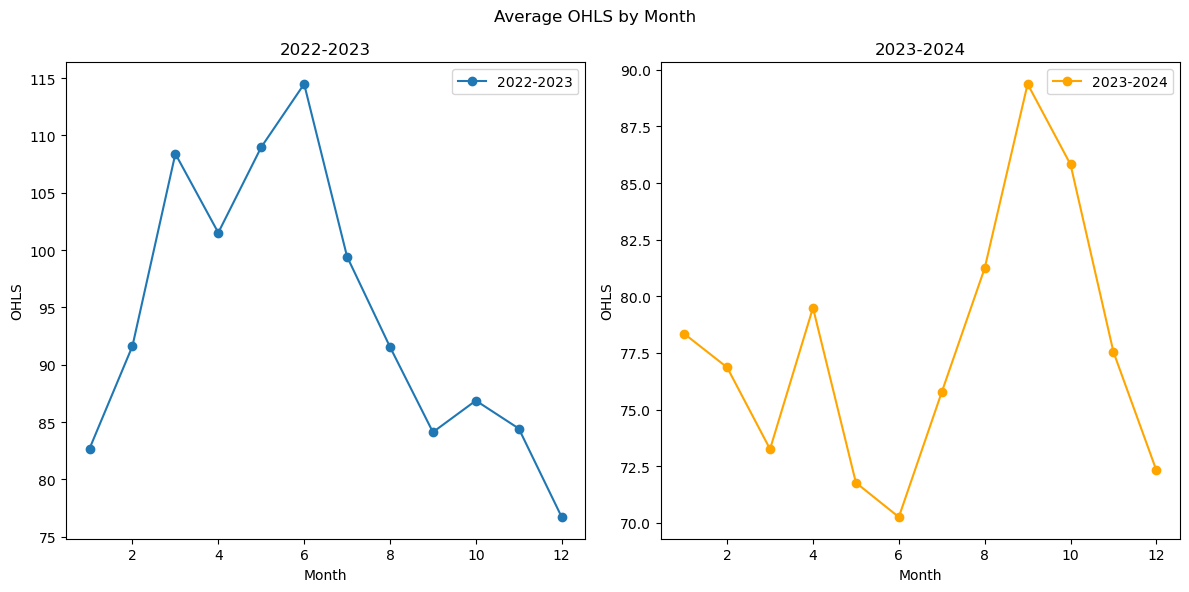

In [78]:
# Построение графиков
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(grouped_2022_2023['month'], grouped_2022_2023['OHLS'], marker='o', linestyle='-', label='2022-2023')
plt.title('2022-2023')
plt.xlabel('Month')
plt.ylabel('OHLS')
plt.legend()

plt.subplot(122)
plt.plot(grouped_2023_2024['month'], grouped_2023_2024['OHLS'], marker='o', linestyle='-', color='orange', label='2023-2024')
plt.title('2023-2024')
plt.xlabel('Month')
plt.ylabel('OHLS')
plt.legend()

plt.suptitle('Average OHLS by Month')
plt.tight_layout()
plt.show()

In [82]:
grouped_2022_2023_volume = group_by_months(dataset_2022_2023,'volume')
grouped_2023_2024_volume = group_by_months(dataset_2023_2024,'volume')

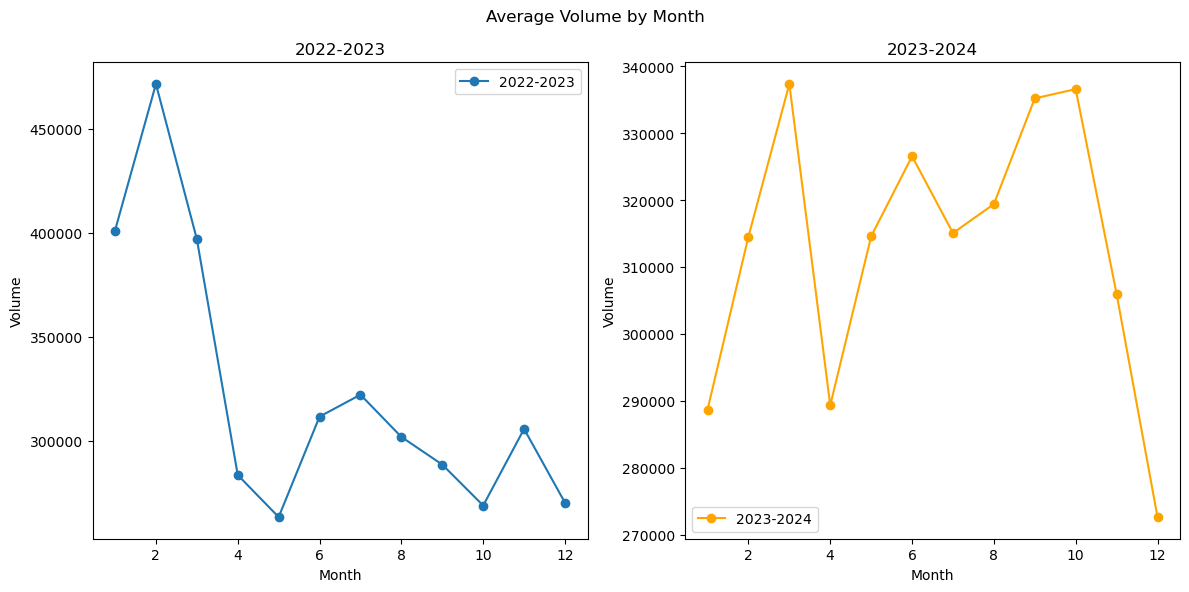

In [84]:
# Построение графиков
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(grouped_2022_2023_volume['month'], grouped_2022_2023_volume['volume'], marker='o', linestyle='-', label='2022-2023')
plt.title('2022-2023')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()

plt.subplot(122)
plt.plot(grouped_2023_2024_volume['month'], grouped_2023_2024_volume['volume'], marker='o', linestyle='-', color='orange', label='2023-2024')
plt.title('2023-2024')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()

plt.suptitle('Average Volume by Month')
plt.tight_layout()
plt.show()

In [86]:
WTI.loc[:,'OHLS_3_ago'] = log_ago(WTI.loc[:,'OHLS'],3)